# ERC Risk Premia Portfolio Backtest

In this notebook we backtest a more advanced risk parity long-only portfolio of ETFs.

Review the basic riskpremia notebook in this directory first.

In [104]:
import os
import sys
import importlib
from itertools import repeat
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import ffn

%matplotlib inline

In [105]:
# Ensure the notebook can find local modules by appending the parent directory to the system path
# Requires a 'donotdelete.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

# Import local modules with hot reload
import alphasim.backtest
importlib.reload(alphasim.backtest)
from alphasim.backtest import backtest

import alphasim.stats
importlib.reload(alphasim.stats)
from alphasim.stats import calc_stats, calc_log_returns, calc_rolling_ann_vola

In [106]:
tickers = ['VTI', 'TLT', 'GLD']
ticker_n = len(tickers)
price_df = pdr.get_data_yahoo(tickers, start='2000-01-01').dropna()
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-18,41.046688,50.798927,44.380001
2004-11-19,40.548496,50.393528,44.779999
2004-11-22,40.815376,50.656193,44.950001
2004-11-23,40.829617,50.718964,44.750000
2004-11-24,41.064476,50.718964,45.049999
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


## ERC Weights

Define weights based on the rolling co-variance and the equal risk contribution (ERC) algorithm.

In [107]:
# Sensible EWMA alphas
ewma_vol_alpha = 1.-0.94
ewma_cov_alpha = 1.-0.975

# Calc required time series
ret_df = np.log(price_df/price_df.shift(1)).dropna()
cumret_df = ret_df.cumsum()
vola_df = ret_df.ewm(alpha=ewma_vol_alpha, adjust=False).std() * np.sqrt(252)
cov_df = ret_df.ewm(alpha=ewma_cov_alpha, adjust=False).cov().dropna()
cov_mat = cov_df.groupby('Date').apply(lambda x: x.values)

In [108]:
# Function to calculate ERC weights for each period
def calc_erc_weight(initial_weights, cov_mat, b):
    n = len(initial_weights)
    try:
        w = ffn.core._erc_weights_ccd(initial_weights, cov=cov_mat, b=b, maximum_iterations=1000, tolerance=1e-8)
    except ValueError:
        w = np.full(n, np.NaN)
    return w

In [117]:
# Define our risk budget as equal risk
risk_budget = np.full(ticker_n, 1/ticker_n)

# Get ERC weights
weight_df = ret_df[:-1].copy()
weight_df[:] = [calc_erc_weight(x, y, z) for x, y, z in zip(
    weight_df.shift(1).values, cov_mat, repeat(risk_budget))]
weight_df = weight_df.dropna()
display(weight_df)

weight_df.to_csv("./weight_sample.csv")

Symbols,VTI,TLT,GLD
Date,,,
2004-11-22,0.182878,0.269341,0.547780
2004-11-23,0.140551,0.286660,0.572788
2004-11-24,0.141159,0.286179,0.572663
2004-11-26,0.185775,0.250529,0.563696
2004-11-29,0.215497,0.298860,0.485643
...,...,...,...
2022-09-30,0.277624,0.316092,0.406284
2022-10-03,0.268306,0.329628,0.402066
2022-10-04,0.269468,0.329009,0.401523


In [118]:
price_df = price_df.align(weight_df, axis=0, join='inner')[0]

price_df.to_csv("price_sample.csv")

display(price_df)

Symbols,VTI,TLT,GLD,cash
Date,,,,
2004-11-22,40.815376,50.656193,44.950001,1.0
2004-11-23,40.829617,50.718964,44.750000,1.0
2004-11-24,41.064476,50.718964,45.049999,1.0
2004-11-26,41.064476,50.387825,45.290001,1.0
2004-11-29,40.975521,49.851147,45.400002,1.0
...,...,...,...,...
2022-09-30,179.470001,102.206001,154.669998,1.0
2022-10-03,184.029999,103.830002,158.429993,1.0
2022-10-04,189.940002,103.540001,160.699997,1.0


In [116]:
def fixed_min_commission(trade_price, trade_size):
    return 1

result_df = backtest(
    prices=price_df, 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result_df)

price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2004-11-22 VTI       40.815376         0.000000      0.000000        0.000000   
           TLT       50.656193         0.000000      0.000000        0.000000   
           GLD       44.950001         0.000000      0.000000        0.000000   
           cash       1.000000     10000.000000  10000.000000        1.000000   
2004-11-23 VTI       40.829617        44.806250   1829.421999        0.183371   
...                        ...              ...           ...             ...   
2022-10-05 cash       1.000000       581.757792    581.757792        0.014874   
2022-10-06 VTI      187.770004        54.810593  10291.785312        0.264381   
           TLT      101.980003       119.287307  12164.919928        0.312499   
           GLD      159.630005        99.539008  15889.412392        0.408176   
           cash       1.000000       581.757792    581.757792        0.014945   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2004-11-22 VTI           0.182878      0.182878      True           0.182878   
           TLT           0.269341      0.269341      True           0.269341   
           GLD           0.547780      0.547780      True           0.547780   
           cash          0.000000     -1.000000     False           1.000000   
2004-11-23 VTI           0.140551     -0.042820      True           0.140551   
...                           ...           ...       ...                ...   
2022-10-05 cash          0.000000     -0.014874     False           0.014874   
2022-10-06 VTI           0.262572     -0.001809     False           0.264381   
           TLT           0.333912      0.021413     False           0.312499   
           GLD           0.403516     -0.004659     False           0.408176   
           cash          0.000000     -0.014945     False           0.014945   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2004-11-22 VTI              0.182878  1828.783946   44.806250         1.0   
           TLT              0.269341  2693.412572   53.170450         1.0   
           GLD              0.547780  5477.803482  121.864369         1.0   
           cash             0.000000     0.000000    0.000000         0.0   
2004-11-23 VTI             -0.042820  -427.197751  -10.462938         1.0   
...                              ...          ...         ...         ...   
2022-10-05 cash             0.000000     0.000000    0.000000         0.0   
2022-10-06 VTI              0.000000     0.000000    0.000000         0.0   
           TLT              0.000000     0.000000    0.000000         0.0   
           GLD              0.000000     0.000000    0.000000         0.0   
           cash             0.000000     0.000000    0.000000         0.0   

                    end_portfolio  
datetime   Symbols                 
2004-11-22 VTI          44.806250  
           TLT          53.170450  
           GLD         121.864369  
           cash         -3.000000  
2004-11-23 VTI          34.343312  
...                           ...  
2022-10-05 cash        581.757792  
2022-10-06 VTI          54.810593  
           TLT         119.287307  
           GLD          99.539008  
           cash        581.757792  

[18000 rows x 13 columns]

In [112]:
trades_df = result_df.loc[result_df['do_trade'] == True]
display(len(trades_df))
display(trades_df.tail(5))

286

,,price,start_portfolio,equity,current_weight,target_weight,delta_weight,do_trade,adj_target_weight,adj_delta_weight,trade_value,trade_size,commission,end_portfolio
datetime,Symbols,,,,,,,,,,,,,
2022-03-08,GLD,191.509995,101.593806,19456.229284,0.418002,0.364311,-0.053691,True,0.364311,-0.053691,-2499.081461,-13.049353,1.0,88.544454
2022-04-04,GLD,180.369995,88.544454,15970.762664,0.343485,0.386136,0.042651,True,0.386136,0.042651,1983.087790,10.994555,1.0,99.539008
2022-04-21,VTI,218.415970,73.899031,16140.728540,0.359990,0.315127,-0.044862,True,0.315127,-0.044862,-2011.482226,-9.209410,1.0,64.689621
2022-05-04,VTI,213.804062,64.689621,13830.903736,0.316343,0.268033,-0.048310,True,0.268033,-0.048310,-2112.176284,-9.879028,1.0,54.810593
2022-05-06,TLT,112.531403,101.261972,11395.151777,0.267095,0.314640,0.047545,True,0.314640,0.047545,2028.416146,18.025334,1.0,119.287307


In [113]:
stat_df = calc_stats(result_df.copy())
display(stat_df)

,equity
start,2004-11-22 00:00:00
end,2022-10-06 00:00:00
rf,0.0
total_return,2.892788
cagr,0.079024
max_drawdown,-0.21346
calmar,0.370204
mtd,0.024251
three_month,-0.045572
six_month,-0.146036


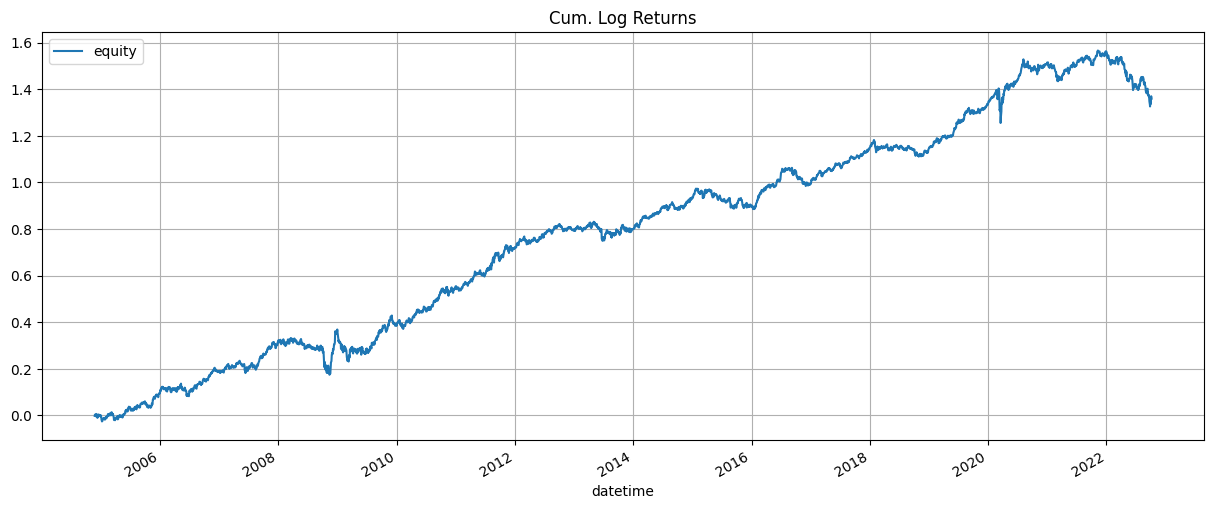

In [114]:
ax = calc_log_returns(result_df).cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

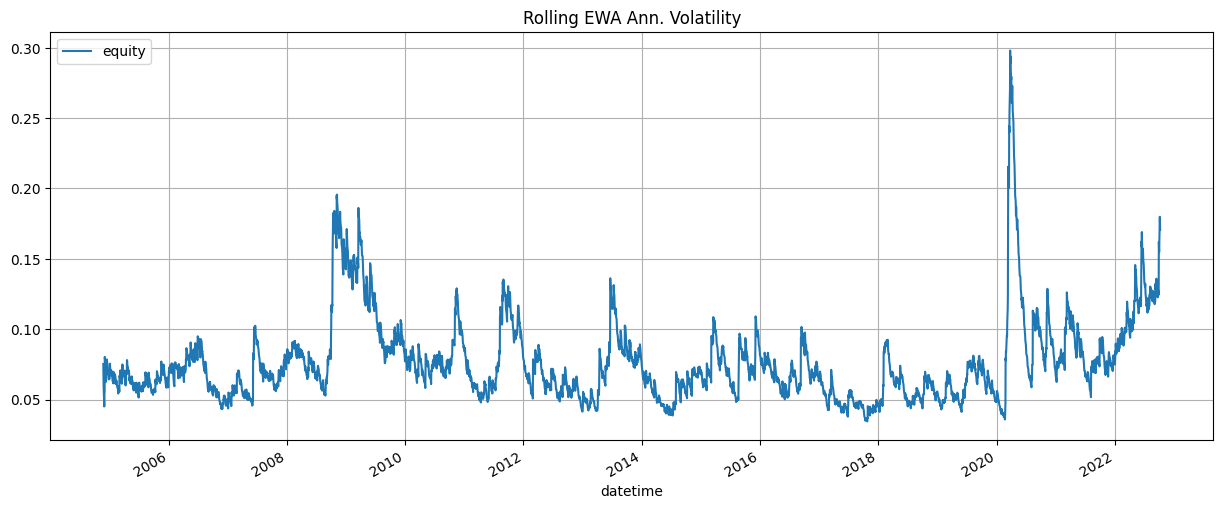

In [115]:
ax = calc_rolling_ann_vola(result_df).plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()